In [22]:
!pip install kagglehub tensorflow scikit-learn matplotlib pandas
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from keras_tuner import Hyperband, HyperParameters



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Step 1: Load the Dataset
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")
train_file = f"{path}/Google_Stock_Price_Train.csv"
test_file = f"{path}/Google_Stock_Price_Test.csv"

# Load datasets
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Step 2: Preprocess Data
# Extract "Open" prices for training
train_prices = train_data['Open'].values.reshape(-1, 1)

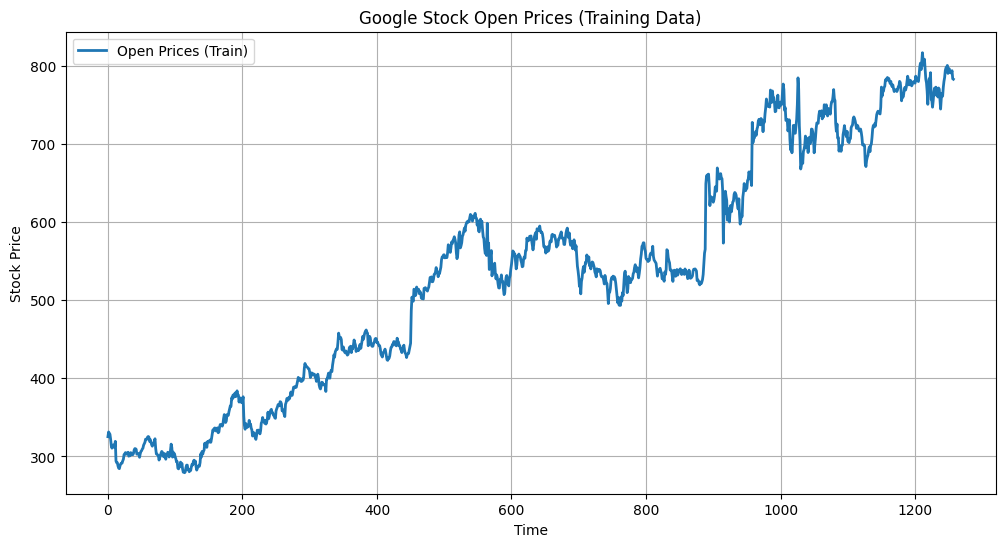

In [17]:

# Visualizations

# Line Plot: Training "Open" prices over time
plt.figure(figsize=(12, 6))
plt.plot(train_data['Open'], label='Open Prices (Train)', linewidth=2)
plt.title('Google Stock Open Prices (Training Data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

c:\Users\vidhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


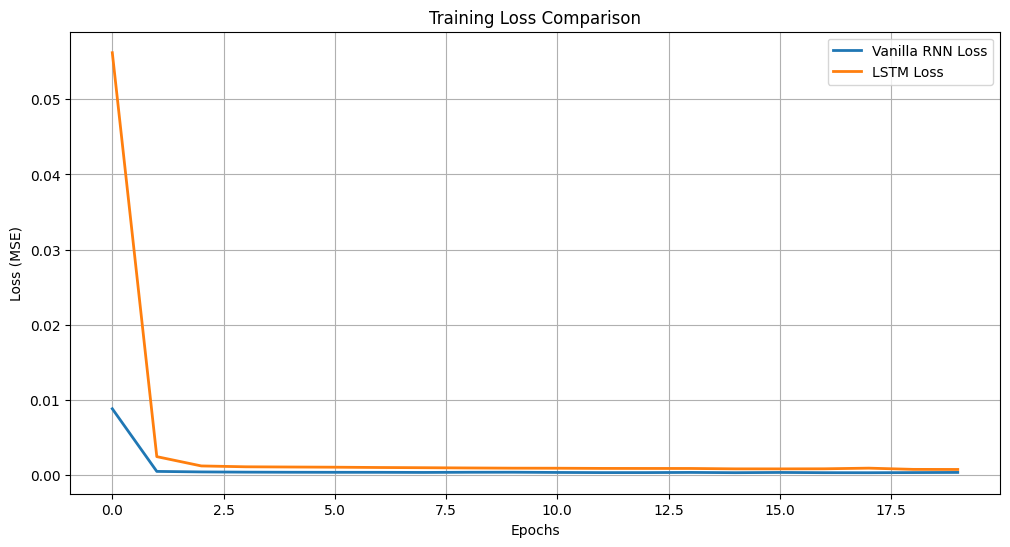

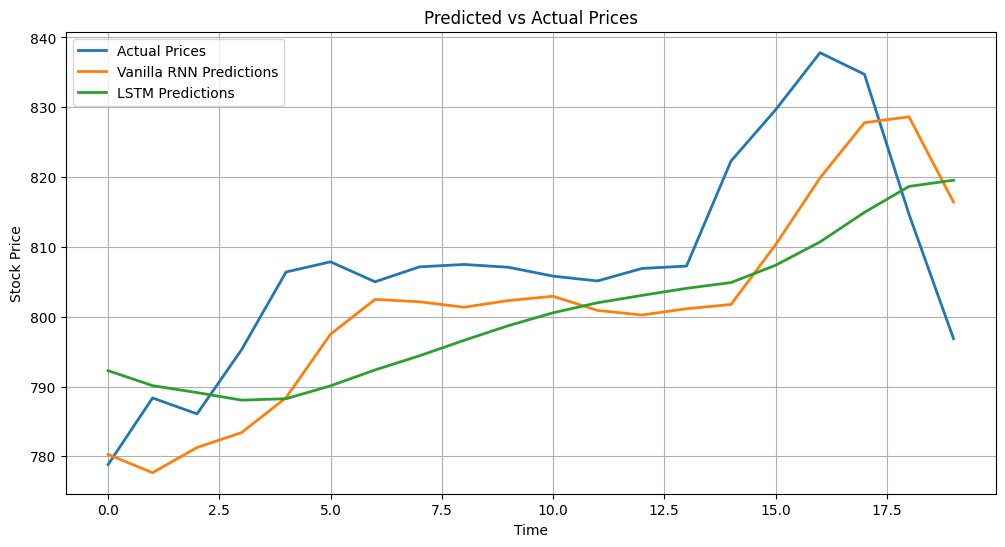

In [19]:

# Preprocess data: Extract "Open" prices and scale
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices = scaler.fit_transform(train_data['Open'].values.reshape(-1, 1))
test_prices = scaler.transform(test_data['Open'].values.reshape(-1, 1))

# Combine train and test data for sequence preparation
full_data = np.concatenate((train_prices, test_prices), axis=0)

# Prepare sequences for training and testing
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60

# Training data sequences
X_train, y_train = create_sequences(train_prices, time_steps)

# Testing data sequences
test_start_idx = len(train_prices) - time_steps
test_data_combined = full_data[test_start_idx:]  # Combine last `time_steps` of train with test
X_test, y_test = create_sequences(test_data_combined, time_steps)

# Reshape for RNN and LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Baseline Model 1: Vanilla RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Baseline Model 2: LSTM
lstm_model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Predictions
rnn_predictions = scaler.inverse_transform(rnn_model.predict(X_test))
lstm_predictions = scaler.inverse_transform(lstm_model.predict(X_test))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot: Training Loss
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='Vanilla RNN Loss', linewidth=2)
plt.plot(lstm_history.history['loss'], label='LSTM Loss', linewidth=2)
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# Plot: Predicted vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(rnn_predictions, label='Vanilla RNN Predictions', linewidth=2)
plt.plot(lstm_predictions, label='LSTM Predictions', linewidth=2)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Trial 7 Complete [00h 00m 03s]
mse: 0.000848855881486088

Best mse So Far: 0.0007598864613100886
Total elapsed time: 00h 00m 22s


c:\Users\vidhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0179 - mse: 0.0179         
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4788e-04 - mse: 5.4788e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8708e-04 - mse: 3.8708e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4175e-04 - mse: 4.4175e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8259e-04 - mse: 3.8259e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9631e-04 - mse: 3.9631e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3204e-04 - mse: 3.3204e-04
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1505e-04 - mse: 4.1505e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7856e-04 - mse: 3.7856e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2925e-04 - mse: 3.2925e-04
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1516e-04 - mse: 3.1516e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

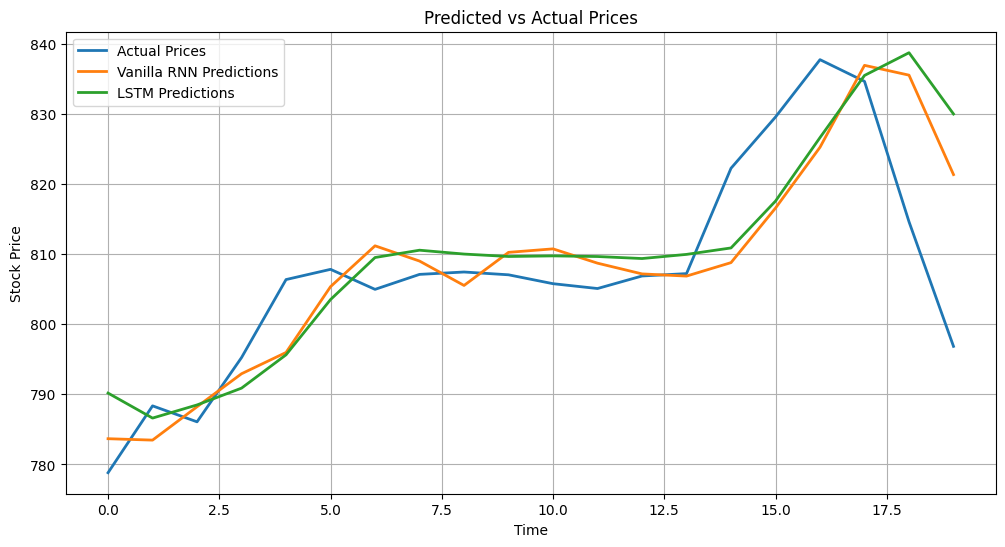

In [23]:


# Preprocess data: Extract "Open" prices and scale
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices = scaler.fit_transform(train_data['Open'].values.reshape(-1, 1))
test_prices = scaler.transform(test_data['Open'].values.reshape(-1, 1))

# Combine train and test data for sequence preparation
full_data = np.concatenate((train_prices, test_prices), axis=0)

# Prepare sequences for training and testing
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60

# Training data sequences
X_train, y_train = create_sequences(train_prices, time_steps)

# Testing data sequences
test_start_idx = len(train_prices) - time_steps
test_data_combined = full_data[test_start_idx:]  # Combine last `time_steps` of train with test
X_test, y_test = create_sequences(test_data_combined, time_steps)

# Reshape for RNN and LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Hyperparameter tuning function for RNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=16),
                        activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Hyperparameter tuning function for LSTM
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16),
                   activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Tuner for RNN
rnn_tuner = Hyperband(
    build_rnn_model,
    objective='mse',
    max_epochs=20,
    directory='hyperband_rnn',
    project_name='google_stock_rnn'
)

# Tuner for LSTM
lstm_tuner = Hyperband(
    build_lstm_model,
    objective='mse',
    max_epochs=20,
    directory='hyperband_lstm',
    project_name='google_stock_lstm'
)

# Run the hyperparameter search for RNN
rnn_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Run the hyperparameter search for LSTM
lstm_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best RNN model
best_rnn_model = rnn_tuner.get_best_models(num_models=1)[0]

# Get the best LSTM model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

# Train the best models on the full training data
best_rnn_model.fit(X_train, y_train, epochs=20, batch_size=32)
best_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predictions
rnn_predictions = scaler.inverse_transform(best_rnn_model.predict(X_test))
lstm_predictions = scaler.inverse_transform(best_lstm_model.predict(X_test))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot: Predicted vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(rnn_predictions, label='Vanilla RNN Predictions', linewidth=2)
plt.plot(lstm_predictions, label='LSTM Predictions', linewidth=2)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Reloading Tuner from hyperband_lstm\google_stock_lstm\tuner0.json
Epoch 1/20


c:\Users\vidhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\vidhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.3324e-04 - mse: 6.3324e-04 - val_loss: 9.9668e-04 - val_mse: 9.9668e-04
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3922e-04 - mse: 6.3922e-04 - val_loss: 9.8018e-04 - val_mse: 9.8018e-04
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.1513e-04 - mse: 6.1513e-04 - val_loss: 8.5896e-04 - val_mse: 8.5896e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6101e-04 - mse: 6.6101e-04 - val_loss: 9.2545e-04 - val_mse: 9.2545e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7801e-04 - mse: 4.7801e-04 - val_loss: 7.2956e-04 - val_mse: 7.2956e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.5351e-04 - mse: 5.5351e-04 - val_loss: 6.9793e-04 - val_mse: 6.9793e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7150e-04 - mse: 5.7150e-04 - val_lo

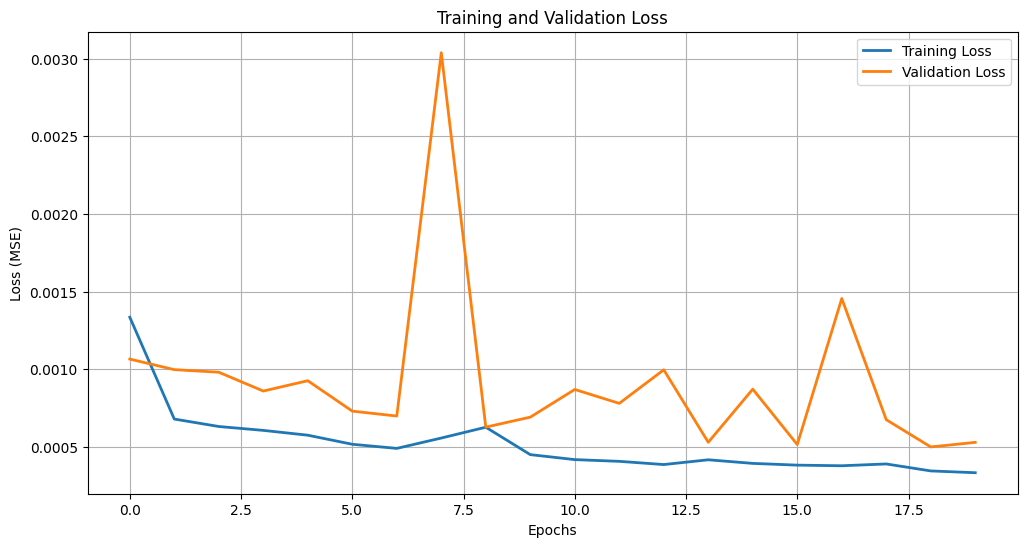

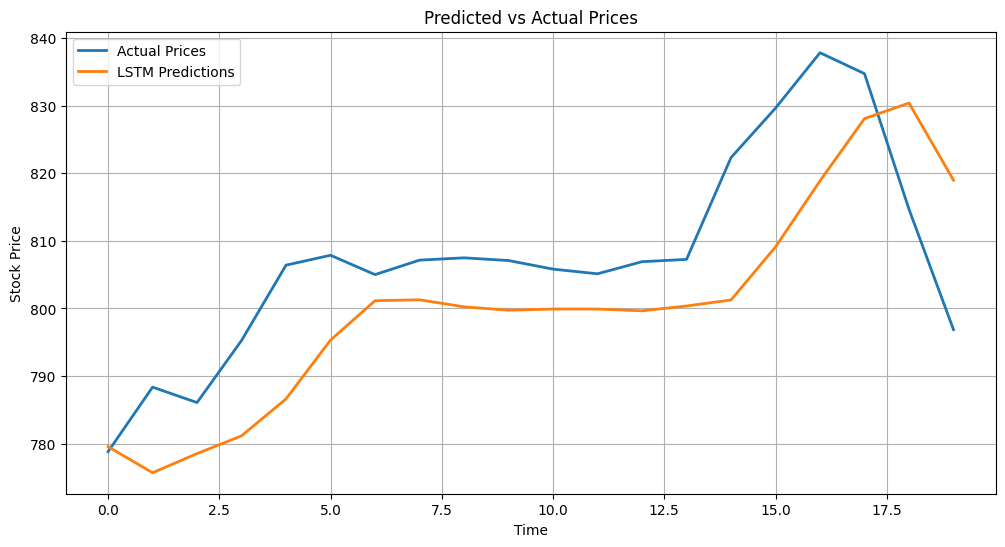

In [25]:

# Preprocess data: Extract "Open" prices and scale
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices = scaler.fit_transform(train_data['Open'].values.reshape(-1, 1))
test_prices = scaler.transform(test_data['Open'].values.reshape(-1, 1))

# Combine train and test data for sequence preparation
full_data = np.concatenate((train_prices, test_prices), axis=0)

# Prepare sequences for training and testing
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60

# Training data sequences
X_train, y_train = create_sequences(train_prices, time_steps)

# Testing data sequences
test_start_idx = len(train_prices) - time_steps
test_data_combined = full_data[test_start_idx:]  # Combine last `time_steps` of train with test
X_test, y_test = create_sequences(test_data_combined, time_steps)

# Reshape for RNN and LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Hyperparameter tuning function for LSTM
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16),
                   activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Tuner for LSTM
lstm_tuner = Hyperband(
    build_lstm_model,
    objective='mse',
    max_epochs=20,
    directory='hyperband_lstm',
    project_name='google_stock_lstm'
)

# Run the hyperparameter search
lstm_tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

# Train the best model on the full training data
history = best_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the best model on test data
test_loss = best_lstm_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss (MSE):", test_loss)

# Predictions
lstm_predictions = scaler.inverse_transform(best_lstm_model.predict(X_test))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot: Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# Plot: Predicted vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(lstm_predictions, label='LSTM Predictions', linewidth=2)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


Epoch 1/20


c:\Users\vidhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0718 - mse: 0.0718 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.8462e-04 - mse: 9.8462e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3398e-04 - mse: 8.3398e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.4143e-04 - mse: 9.4143e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6372e-04 - mse: 8.6372e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0757e-04 - mse: 9.0757e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━

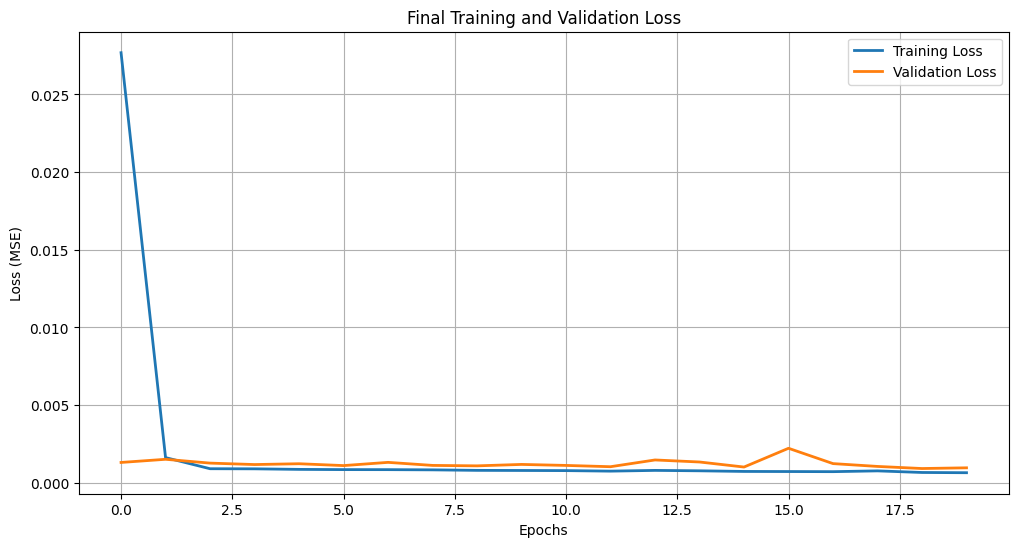

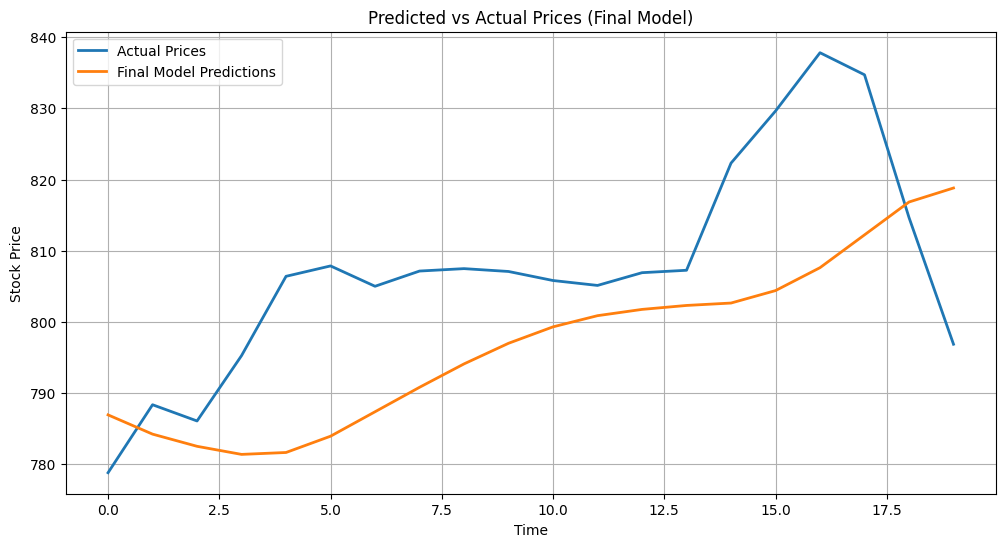

In [26]:
# Retrieve the best hyperparameters
best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model using the best hyperparameters
final_model = Sequential()
final_model.add(LSTM(units=best_hps.get('units'),
                     activation='tanh',
                     input_shape=(X_train.shape[1], 1)))
final_model.add(Dense(1))
final_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Retrain the model on the entire training dataset
final_history = final_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test dataset
final_test_loss = final_model.evaluate(X_test, y_test, verbose=0)
print("Final Test Loss (MSE):", final_test_loss)

# Predictions
final_predictions = scaler.inverse_transform(final_model.predict(X_test))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot: Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(final_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Final Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# Plot: Predicted vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', linewidth=2)
plt.plot(final_predictions, label='Final Model Predictions', linewidth=2)
plt.title('Predicted vs Actual Prices (Final Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()
